In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import matplotlib as mpl, warnings
import numpy as np
from sklearn.decomposition import PCA

In [20]:
m = 'dis'
exps  = ['exp1','exp2','exp3', 'exp4']
funcs = ['sphere','rastrigin','rosenbrock']
freq = 10
nn_p = 5
nn_w = 5
nn_tw = 1
dimension=30
norm_check = np.sqrt(dimension*(10**2)) #10=5-(-5) this line is to normalize error values, we divide them to the biggest distance between two points in decision space 

In [21]:
df = get_data(m)
df = df[(df['nnw']==str(nn_w))&(df['nntw']==str(nn_tw))&(df['nnp']==str(nn_p))|(df['isnn']==False)] 


Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [22]:
df = df.sort_values('method')

In [23]:
# df.query(f'method=="NN_RI"')

In [24]:
def plot_one(exp, func, freq, ax, isnn):
    data = df.query(f'experiment == {exp!r} and function == {func!r} and freq == {freq}')
#     for n,d in data.groupby('method'):
    for n,row in data.iterrows():
        lbl = row.method
        if isnn:
            if 'noNN' not in row.method:
                ax.plot(range(1,100), row[:99].values, label=lbl, linewidth=2, alpha=0.65) #/norm_check
        else:
            if 'noNN' in row.method:
                ax.plot(range(1,100), row[:99].values, label=lbl, linewidth=2, alpha=0.65) #/norm_check
    return ax


def plot_pca_all(func, axs=None):#i added this new pca plot for ppsn paper, to present pcaplot with another format
    exps = sorted([o.stem for o in Path().glob(f'*{func}*.npy')]) # retrieving file names
    source_data = []
    for exp in exps: source_data.append(pd.DataFrame(np.load(exp+'.npy')).assign(name=exp)) # reading files
    df_source = pd.concat(source_data) # putting all files together in a pandas dataframe
    d = df_source.iloc[:,:30] # grabs the values (30 dim)
    pca = PCA(1) # initialize PCA
    d_pca = pca.fit_transform(d) # reduces dimentions to 1
    dd = df_source.name.to_frame() # grabs from df_source only the names of experiments
    dd['value'] = d_pca[:,0] # adds the reduced dimentions to dd
    plot_data = dd.copy() # putting the data in format to plot
    plot_data['time'] = np.repeat(np.arange(100)[None], len(exps), 0).reshape(-1) # add time values 

    if axs is None: fig,axs = plt.subplots(1, 4, figsize=(16,0.8*len(exps))) # plot figures
    
    for exp,ax in zip(exps,axs):
        texp,tfunc = exp.split('_')
        t = plot_data.query(f"name=={exp!r}")
        ax.plot(t['time'], t['value'] ,'-*', label=exp, c='crimson')
        ax.set_title(f'{texp}-{tfunc.title()}')
        ax.set_xlim(0,100)
    plt.tight_layout()
    return axs

def plot_pca(func, exper, axs=None):#i added this new pca plot for ppsn paper, to present pcaplot with another format
    exps = sorted([o.stem for o in Path().glob(f'*{func}*.npy')]) # retrieving file names
    source_data = []
    for exp in exps: source_data.append(pd.DataFrame(np.load(exp+'.npy')).assign(name=exp)) # reading files
    df_source = pd.concat(source_data) # putting all files together in a pandas dataframe
    d = df_source.iloc[:,:30] # grabs the values (30 dim)
    pca = PCA(1) # initialize PCA
    d_pca = pca.fit_transform(d) # reduces dimentions to 1
    dd = df_source.name.to_frame() # grabs from df_source only the names of experiments
    dd['value'] = d_pca[:,0] # adds the reduced dimentions to dd
    plot_data = dd.copy() # putting the data in format to plot
    plot_data['time'] = np.repeat(np.arange(100)[None], len(exps), 0).reshape(-1) # add time values 

    if axs is None: fig,axs = plt.subplots(1, 4, figsize=(16,0.8*len(exps))) # plot figures
    
#     for exp,ax in zip(exps,axs):
    texp,tfunc = exp.split('_')
    t = plot_data.query(f"name=={exp!r}")
    axs[0].plot(t['time'], t['value'] ,'-*', label=exp, c='crimson')
    axs[1].plot(t['time'], t['value'] ,'-*', label=exp, c='crimson')
#     axs.set_title(f'{texp}-{tfunc.title()}')
#     axs.set_xlim(0,100)
    plt.tight_layout()
    return axs



## one plot only!



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

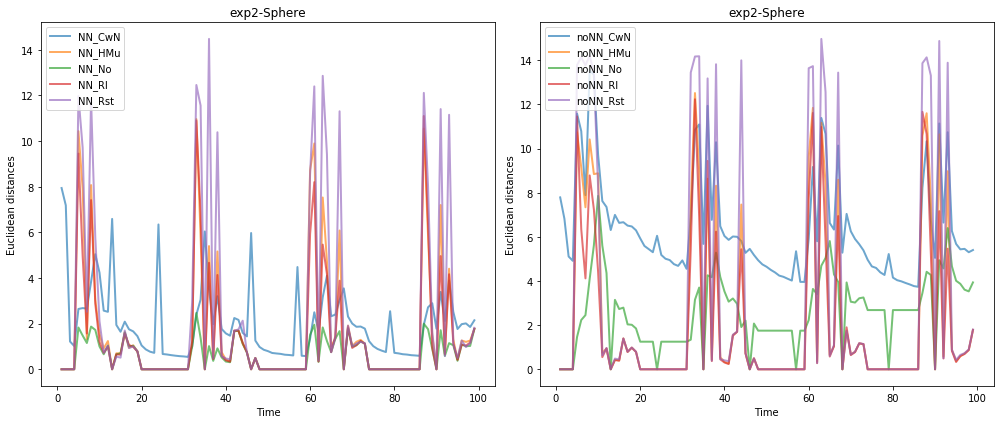

In [25]:
fig,ax_row = plt.subplots(1, 2, figsize=(14,6))
exp='exp2'
func='sphere'
# plot_pca(func,exp,ax_row)
# plot_pca(func,ax_row[1])

# for ax_row in axs:
# ax_row.set_ylabel('pca')
# ax_row.set_xlabel('time')
# ax_row=ax_row.twinx()
plot_one(exp, func, freq, ax_row[0],isnn=True)
plot_one(exp, func, freq, ax_row[1],isnn=False)
ax_row[0].set_title(f'{exp}-{func.title()}')
ax_row[0].ticklabel_format(style='sci', scilimits=(0,5), useOffset=False)
ax_row[0].set_ylabel('Euclidean distances')
ax_row[0].set_xlabel('Time')

ax_row[1].set_xlabel('Time')
ax_row[1].set_title(f'{exp}-{func.title()}')
ax_row[1].ticklabel_format(style='sci', scilimits=(0,5), useOffset=False)
ax_row[1].set_ylabel('Euclidean distances')

ax_row[0].legend(loc='upper left', bbox_to_anchor=(0, 0, 1, 1))
ax_row[1].legend(loc='upper left', bbox_to_anchor=(0, 0, 1, 1))
plt.tight_layout()
freq_lbl = f'{freq*10:02.0f}' if freq<1 else freq

fig.savefig(f'../../data/cluster_results/dis{freq_lbl}.eps', dpi=600, format='eps')

# errors and pca

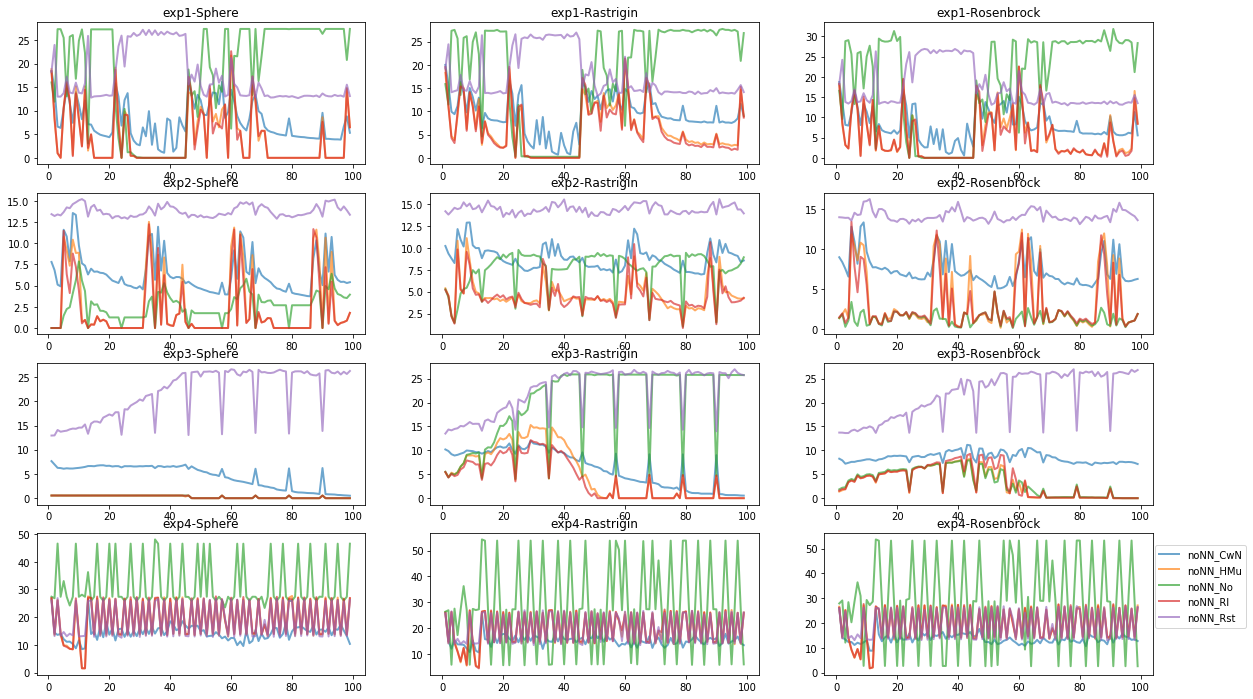

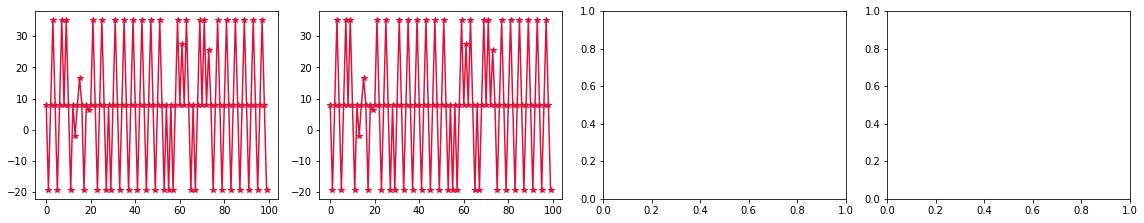

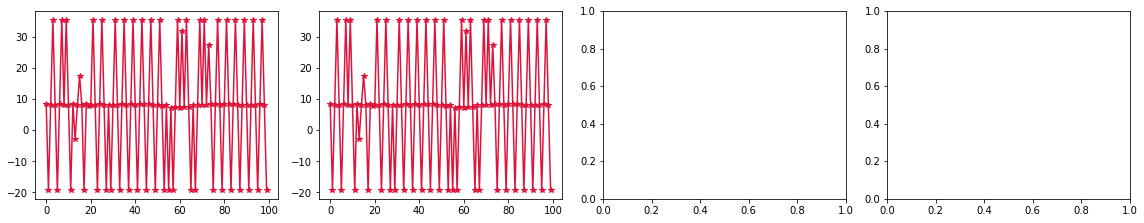

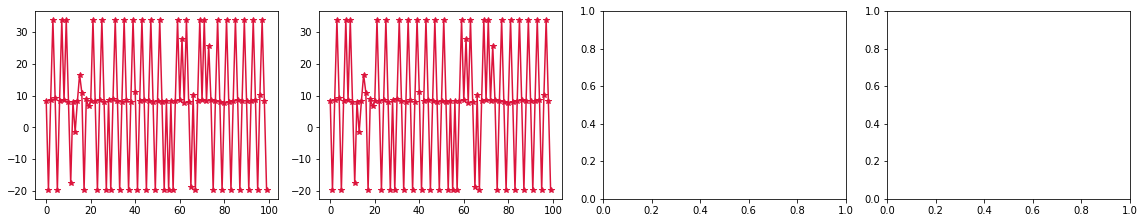

In [16]:
fig,axs = plt.subplots(4, 3, figsize=(20,12))
lbl_dict = None

for ax_row,exp in zip(axs,exps):
    for ax,func in zip(ax_row,funcs):
        plot_one(exp, func, freq, ax, lbl_dict)
        ax.set_title(f'{exp}-{func.title()}')
        ax.ticklabel_format(style='sci', scilimits=(0,5), useOffset=False)
ax.legend(loc='upper right', bbox_to_anchor=(0,0.15, 1.3, 0.8))#, bbox_to_anchor=(0,0, 0.5, 0.5))#best(0, -0.90, 0.5, 0.5)

for i,func in enumerate(['sphere', 'rastrigin', 'rosenbrock']): plot_pca(func, axs[:,i])

plt.tight_layout()
freq_lbl = f'{freq*10:02.0f}' if freq<1 else freq

# fig.savefig(f'../../data/cluster_results/errorpca{freq_lbl}.eps', dpi=400, format='eps')

# Plot errors

In [ ]:
# only errors
fig,axs = plt.subplots(4, 3, figsize=(18,10))
lbl_dict = None

for ax_row,exp in zip(axs,exps):
    for ax,func in zip(ax_row,funcs):
        plot_one(exp, func, freq, ax, lbl_dict)
        ax.set_title(f'{exp}-{func.title()}')
        ax.ticklabel_format(style='sci', scilimits=(0,5), useOffset=False)
#         if ax.get_ylim()[1] < 1e5:
# #             ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#             ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.legend(loc='upper right', bbox_to_anchor=(0,0.15, 1.3, 0.8))#, bbox_to_anchor=(0,0, 0.5, 0.5))#best(0, -0.90, 0.5, 0.5)
plt.tight_layout()
freq_lbl = f'{freq*10:02.0f}' if freq<1 else freq

fig.savefig(f'../../data/cluster_results/error{freq_lbl}.eps', dpi=400, format='eps')

# Plot PCA

In [ ]:
axs = plot_pca('sphere')
# fig.savefig(f'../../data/cluster_results/pcaPlot.eps', dpi=400, format='eps')
# plot_function('rosenbrock')
# plot_function('rastrigin')
#save(str(path/'pcaPlot.png'), scale_factor=2)